NLTK

In [29]:
import pandas as pd
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import string

# Download all necessary NLTK data 

nltk.download('punkt')
nltk.download('punkt_tab') 
nltk.download('stopwords')
nltk.download('wordnet')

[nltk_data] Downloading package punkt to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/pradhyumnyadav/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [30]:
# Load the dataset
df = pd.read_excel('ai_dev_assignment_tickets_complex_1000.xls')

In [31]:
# Initialize lemmatizer and stopwords
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words('english'))

In [32]:
def preprocess_text(text):
    """
    Cleans and preprocesses a given text.
    """
    if not isinstance(text, str):
        return ""
    # Lowercase
    text = text.lower()
    # Remove special characters and digits using regex
    text = re.sub(r'[\d\W_]+', ' ', text)
    # Tokenize
    tokens = word_tokenize(text)
    # Remove stopwords and lemmatize
    processed_tokens = [lemmatizer.lemmatize(w) for w in tokens if w not in stop_words and len(w) > 1]
    return " ".join(processed_tokens)

In [33]:
# Apply preprocessing to the 'ticket_text' column
if not df.empty:
    df['cleaned_text'] = df['ticket_text'].apply(preprocess_text)
    
    # Handle missing data
    df.dropna(subset=['issue_type', 'urgency_level'], inplace=True)
    
    print("Data after preprocessing:")
    print(df[['ticket_text', 'cleaned_text', 'issue_type', 'urgency_level']].head())
else:
    print("DataFrame is empty. Please check the input file.")

Data after preprocessing:
                                         ticket_text  \
0  Payment issue for my SmartWatch V2. I was unde...   
2  I ordered SoundWave 300 but got EcoBreeze AC i...   
3  Facing installation issue with PhotoSnap Cam. ...   
5  Can you tell me more about the PhotoSnap Cam w...   
6   is malfunction. It stopped working after just...   

                                        cleaned_text          issue_type  \
0         payment issue smartwatch underbilled order     Billing Problem   
2  ordered soundwave got ecobreeze ac instead ord...          Wrong Item   
3  facing installation issue photosnap cam setup ...  Installation Issue   
5     tell photosnap cam warranty also available red     General Inquiry   
6                    malfunction stopped working day      Product Defect   

  urgency_level  
0        Medium  
2        Medium  
3           Low  
5        Medium  
6           Low  


Feature engineering

In [34]:
from sklearn.feature_extraction.text import TfidfVectorizer
from textblob import TextBlob

# --- TF-IDF Vectorization ---
tfidf_vectorizer = TfidfVectorizer(max_features=1000)
X_tfidf = tfidf_vectorizer.fit_transform(df['cleaned_text']).toarray()



# Ticket length
df['ticket_length'] = df['cleaned_text'].apply(len)

# Sentiment score
df['sentiment'] = df['cleaned_text'].apply(lambda text: TextBlob(text).sentiment.polarity)

# --- Combine Features ---
additional_features = df[['ticket_length', 'sentiment']].values
X_combined = np.hstack((X_tfidf, additional_features))

print("Shape of combined features:", X_combined.shape)

Shape of combined features: (876, 106)


Multi-Task Learning: Classifiers

--- Issue Type Classifier Evaluation ---
Accuracy: 0.9431818181818182
                    precision    recall  f1-score   support

    Account Access       1.00      0.97      0.99        35
   Billing Problem       1.00      0.91      0.95        32
   General Inquiry       0.74      1.00      0.85        29
Installation Issue       1.00      0.92      0.96        24
     Late Delivery       1.00      0.90      0.95        20
    Product Defect       1.00      0.95      0.97        19
        Wrong Item       1.00      0.94      0.97        17

          accuracy                           0.94       176
         macro avg       0.96      0.94      0.95       176
      weighted avg       0.96      0.94      0.95       176


--- Urgency Level Classifier Evaluation ---
Accuracy: 0.3125
              precision    recall  f1-score   support

        High       0.33      0.33      0.33        60
         Low       0.25      0.26      0.25        54
      Medium       0.35      0.34      0.3

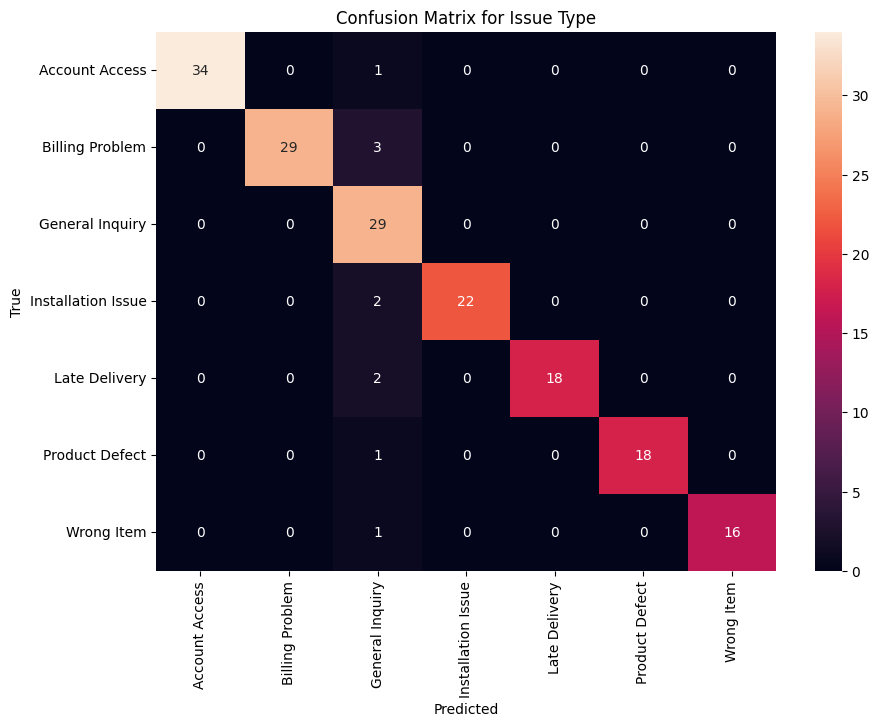

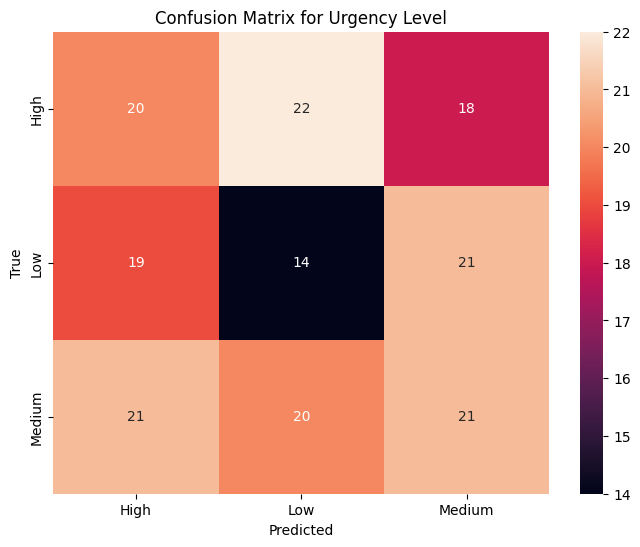

In [35]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import seaborn as sns
import matplotlib.pyplot as plt

# --- Prepare Labels ---
y_issue = df['issue_type']
y_urgency = df['urgency_level']

# --- Split Data ---
X_train_issue, X_test_issue, y_train_issue, y_test_issue = train_test_split(X_combined, y_issue, test_size=0.2, random_state=42)
X_train_urgency, X_test_urgency, y_train_urgency, y_test_urgency = train_test_split(X_combined, y_urgency, test_size=0.2, random_state=42)

# --- Issue Type Classifier ---
issue_classifier = RandomForestClassifier(random_state=42)
issue_classifier.fit(X_train_issue, y_train_issue)
y_pred_issue = issue_classifier.predict(X_test_issue)

print("--- Issue Type Classifier Evaluation ---")
print("Accuracy:", accuracy_score(y_test_issue, y_pred_issue))
print(classification_report(y_test_issue, y_pred_issue))

# --- Urgency Level Classifier ---
urgency_classifier = RandomForestClassifier(random_state=42)
urgency_classifier.fit(X_train_urgency, y_train_urgency)
y_pred_urgency = urgency_classifier.predict(X_test_urgency)

print("\n--- Urgency Level Classifier Evaluation ---")
print("Accuracy:", accuracy_score(y_test_urgency, y_pred_urgency))
print(classification_report(y_test_urgency, y_pred_urgency))

# --- Visualization (Bonus) ---

# Confusion Matrix for Issue Type
cm_issue = confusion_matrix(y_test_issue, y_pred_issue)
plt.figure(figsize=(10, 7))
sns.heatmap(cm_issue, annot=True, fmt='d', xticklabels=issue_classifier.classes_, yticklabels=issue_classifier.classes_)
plt.title('Confusion Matrix for Issue Type')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

# Confusion Matrix for Urgency Level
cm_urgency = confusion_matrix(y_test_urgency, y_pred_urgency)
plt.figure(figsize=(8, 6))
sns.heatmap(cm_urgency, annot=True, fmt='d', xticklabels=urgency_classifier.classes_, yticklabels=urgency_classifier.classes_)
plt.title('Confusion Matrix for Urgency Level')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Entity Extraction

In [36]:
def extract_entities(text):
    """
    Extracts entities (product names, dates, complaint keywords) from text.
    """
    # Product names (you can expand this list based on the dataset)
    products = ['alpha', 'beta', 'gamma', 'delta', 'epsilon']
    found_products = [p for p in products if re.search(r'\b' + p + r'\b', text, re.IGNORECASE)]

    # Dates (extracts in various formats)
    dates = re.findall(r'\d{1,2}[/-]\d{1,2}[/-]\d{2,4}|\b\d{1,2} \w+ \d{4}\b', text)

    # Complaint keywords
    complaint_keywords = ['broken', 'late', 'error', 'fail', 'not working', 'issue', 'problem']
    found_keywords = [kw for kw in complaint_keywords if re.search(r'\b' + kw + r'\b', text, re.IGNORECASE)]

    return {
        "products": list(set(found_products)),
        "dates": dates,
        "complaint_keywords": list(set(found_keywords))
    }

# Example
example_text = "My alpha product has an error and failed on 12/03/2024. The delivery was also late."
print(extract_entities(example_text))

{'products': ['alpha'], 'dates': ['12/03/2024'], 'complaint_keywords': ['error', 'late']}


 Integration

In [37]:
def process_ticket(ticket_text):
    """
    Takes raw ticket text and returns predictions and extracted entities.
    """
    # 1. Preprocess the text
    cleaned_text = preprocess_text(ticket_text)

    # 2. Feature Engineering
    tfidf_features = tfidf_vectorizer.transform([cleaned_text]).toarray()
    ticket_length = len(cleaned_text)
    sentiment = TextBlob(cleaned_text).sentiment.polarity
    combined_features = np.hstack((tfidf_features, [[ticket_length, sentiment]]))

    # 3. Predictions
    predicted_issue = issue_classifier.predict(combined_features)[0]
    predicted_urgency = urgency_classifier.predict(combined_features)[0]

    # 4. Entity Extraction
    entities = extract_entities(ticket_text)

    return {
        "predicted_issue_type": predicted_issue,
        "predicted_urgency_level": predicted_urgency,
        "extracted_entities": entities
    }

# Example usage
new_ticket = "The beta product I ordered on 15 May 2024 is not working. This is a major issue."
result = process_ticket(new_ticket)
print(result)

{'predicted_issue_type': 'Product Defect', 'predicted_urgency_level': 'High', 'extracted_entities': {'products': ['beta'], 'dates': ['15 May 2024'], 'complaint_keywords': ['not working', 'issue']}}


In [38]:

import gradio as gr

def gradio_interface(ticket_text):
    """
    Gradio interface function.
    """
    result = process_ticket(ticket_text)
    return result['predicted_issue_type'], result['predicted_urgency_level'], result['extracted_entities']

iface = gr.Interface(
    fn=gradio_interface,
    inputs=gr.Textbox(lines=5, label="Enter Ticket Text"),
    outputs=[
        gr.Textbox(label="Predicted Issue Type"),
        gr.Textbox(label="Predicted Urgency Level"),
        gr.JSON(label="Extracted Entities")
    ],
    title="Customer Support Ticket Classification and Entity Extraction",
    description="Enter a customer support ticket to get predictions on the issue type, urgency, and to extract key entities."
)

iface.launch()

/Users/pradhyumnyadav/Desktop/vijayi /venv/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.
